In [27]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
from imblearn.pipeline import Pipeline as ImbPipeline
lemma = WordNetLemmatizer()

In [2]:
train = pd.read_csv('Train.csv')  # Replace with your file path
train.head()

,Text_ID,Data,Response
0,1649,Lunch was surreal .,0
1,4705,It offers certificates of completion for many ...,0
2,3320,No amount of educational funds will drag the p...,0
3,6182,"No, lets stay scattered across the earth and t...",0
4,7594,The two teenagers are charged with assaulting ...,0


In [3]:
train.shape

(7492, 3)

In [4]:
train.isnull().sum()

Text_ID     0
Data        0
Response    0
dtype: int64

In [5]:
train.duplicated().sum()

0

In [6]:
test = pd.read_csv('Test.csv')
test.head()

,Text_ID,Data
0,2882,The cross-dressers and faggots are sure not hi...
1,3933,They ca n't stand toe to toe with the white ma...
2,304,There is an active community here - you just n...
3,3325,"Mate, have you been to Britain ?"
4,2626,They are nothing less than indoctrination cent...


In [7]:
test.shape

(3211, 2)

In [8]:
test.isnull().sum()

Text_ID    0
Data       0
dtype: int64

In [9]:
test.duplicated().sum()

0

In [10]:
train['Text_ID'].nunique(), test['Text_ID'].nunique()

(7492, 3211)

<Axes: xlabel='Response'>

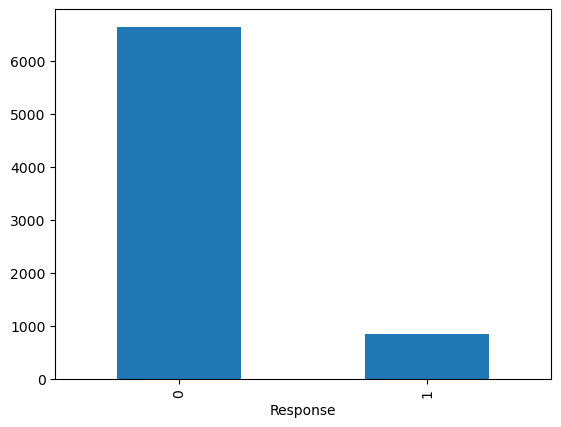

In [11]:
train['Response'].value_counts().plot(kind = 'bar')

In [12]:
text = ' '.join(train['Data'])

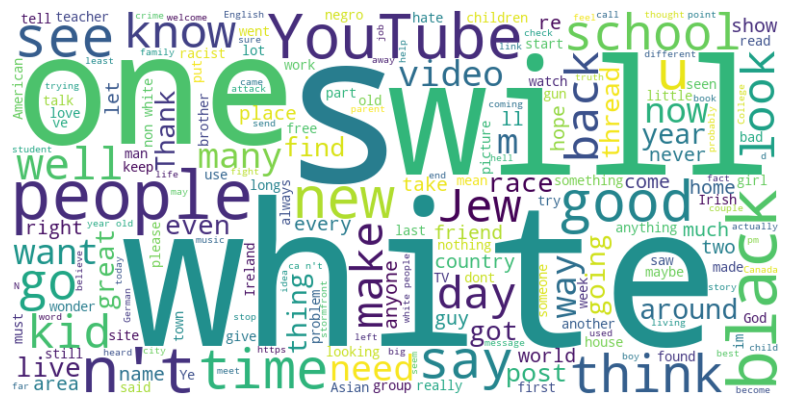

In [13]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()

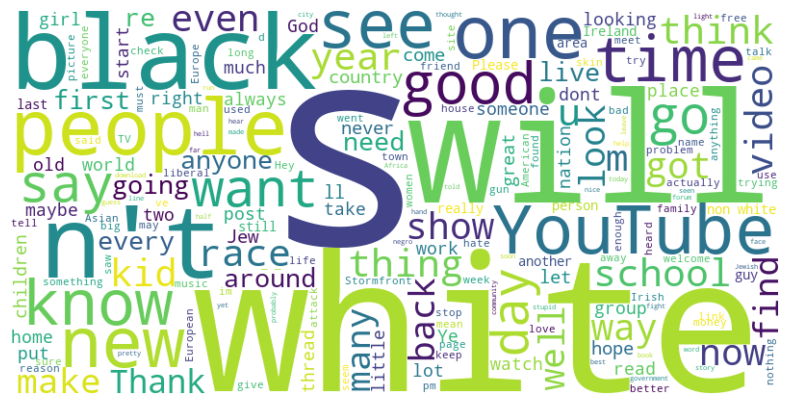

In [14]:
text = ' '.join(test['Data'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()

In [15]:
def preprocess_text(review):
    
    review = review.lower()
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.split()
    review = [word for word in review if not word in set(stopwords.words('english'))]
    review = [lemma.lemmatize(word ) for word in review] 
    return ' '.join(review)

train['cleaned_text'] = train['Data'].astype(str).apply(preprocess_text)

In [16]:
x = train['cleaned_text']
y = train['Response']

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
def create_pipeline(model):
    pipeline = ImbPipeline([
        ('tfidf', TfidfVectorizer()),  
        ('smote', SMOTE()),            
        ('clf', model)                 
    ])
    return pipeline

In [22]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Extra Trees Classifier': ExtraTreesClassifier(),
    'LightGBM Classifier': LGBMClassifier()
}

In [30]:
def evaluate_models(models, x_train, y_train, x_test, y_test):
    best_model = None
    best_f1_score = 0
    best_pipeline = None

    for name, model in models.items():
        print(f"Evaluating {name}...")

        pipeline = create_pipeline(model)

        skf = StratifiedKFold(n_splits=5)
        f1_scores = cross_val_score(pipeline, x_train, y_train, cv=skf, scoring='f1')

        pipeline.fit(x_train, y_train)

        y_pred = pipeline.predict(x_test)

        test_f1 = f1_score(y_test, y_pred)

        print(f"Cross-Validation F1 Score for {name}: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
        print(f"Test F1 Score for {name}: {test_f1:.4f}")
        print(f"f1 score for {name}:\n")
        print(f1_score(y_test, y_pred))
        print("-" * 50)

        # Check if this model is the best based on F1 score
        if test_f1 > best_f1_score:
            best_f1_score = test_f1
            best_model = name
            best_pipeline = pipeline  

    print(f"The best model based on F1 Score is: {best_model} with a F1 Score of {best_f1_score:.4f}")
    return best_pipeline


best_model_pipeline = evaluate_models(models, x_train, y_train, x_test, y_test)

Evaluating Logistic Regression...
Cross-Validation F1 Score for Logistic Regression: 0.4439 ± 0.0276
Test F1 Score for Logistic Regression: 0.4142
f1 score for Logistic Regression:

0.4141689373297003
--------------------------------------------------
Evaluating Random Forest...
Cross-Validation F1 Score for Random Forest: 0.2297 ± 0.0420
Test F1 Score for Random Forest: 0.1574
f1 score for Random Forest:

0.15740740740740744
--------------------------------------------------
Evaluating Extra Trees Classifier...
Cross-Validation F1 Score for Extra Trees Classifier: 0.3093 ± 0.0220
Test F1 Score for Extra Trees Classifier: 0.2389
f1 score for Extra Trees Classifier:

0.23893805309734512
--------------------------------------------------
Evaluating LightGBM Classifier...
[LightGBM] [Info] Number of positive: 4250, number of negative: 4250
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010308 seconds.
You can set `force_row_wise=true` to remove the

In [32]:
if best_model_pipeline:
    print("\nMaking predictions with the best model...\n")
    y_best_pred = best_model_pipeline.predict(x_test)
    print("Predictions:\n", y_best_pred)


Making predictions with the best model...

Predictions:
 [0 1 1 ... 0 0 1]


In [33]:
test['cleaned_text'] = test['Data'].astype(str).apply(preprocess_text)

In [34]:
x_train = train['cleaned_text']
y_train = train['Response']
x_test = test['cleaned_text']
y_pred = best_model_pipeline.predict(x_test)

In [35]:
solution = pd.DataFrame(y_pred)
solution.columns = ['Response']
solution.head()

,Response
0,0
1,0
2,0
3,0
4,0


In [36]:
solution.to_csv('Solution_New.csv', index = False)